# Libraries
* Execute this cell before going any further.

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

<br/><br/>
<br/><br/>

# Fluorescence properties of ruby

In this lab, we will explore one of the fundamental processes that make lasers possible, using the first-ever lasing medium—ruby! We'll explore the fluorescence of this crystal, along with the competing properties that affect its efficiency (and usefulness as a lasing medium). Before we start working with our data, it's worth putting it in context by talking about the basic physics of lasers.

__Fundamental Physics__
- __Bosons and Fermions__: These terms refer to particles with integer and half-integer spin, respectively. Photons are bosons and Electrons are fermions.
- __The Exclusion Principle for Fermions__ : No two fermions can occupy the same state. This is why there can only be two electrons in an orbital (And why you don't fall through the floor!).
- __Boson Bunching__: Bosons, however, actually prefer to occupy the same quantum state, and tend to "clump together".

__Lasing__
- Ruby (Al$_2$O$_3$ doped with Cr$^{3+}$) is placed in a cavity with partial mirrors on either end.
- A pump light source is used to excite electrons in the Cr$^{3+}$ atoms.
- The excited atoms undergo fluorescence, emitting photons (at a less energetic wavelength than the pump frequency).
- When a fluorescent photon passes by another excited Cr${^3+}$ ion, it stimulates emission of an identical photon, with the same direction, phase, and polarity (due to boson bunching).
- This cascading process converts incoherent pump light into coherent laser light.

__In this Lab__
We will:
- Explore how the fluorescence lifetime of Ruby changes with temperature
- Determine the rates of different radiative and non-radiative processes
- Write Python code to process large amounts of data 

Understanding these relaxation pathways is necessary for determining the quantum yield of a lasing medium, which impacts its utility in laser applications.

> For students interested in learning more:  [How Lasers Work - A Complete Guide](https://www.youtube.com/watch?v=_JOchLyNO_w)



<br/><br/>

## PART 1 - Fluorescence lifetime

### Ruby Fluorescence Process

In our experiment, the fluorescence process in ruby follows these steps:

- Our Nd:YAG laser excites Cr$^{3+}$ ions in the ruby lattice from the ground state (⁴A₂) to an excited state (⁴T₂)
- From the ⁴T₂ state, rapid thermal relaxation occurs to the slightly lower energy ²E excited state
- The ion then emits a photon and relaxes back to the ground state

This emission pathway is the source of photons used in ruby lasers. However, competing processes can occur:

- Radiative relaxation directly from the ⁴T₂ state
- Non-radiative relaxation from the ⁴T₂ state (where energy is lost as heat)

Both of these alternative pathways are temperature-dependent, which is why we'll examine how fluorescence lifetime changes with temperature.

### Measuring Fluorescence Lifetime

For a decaying exponential of the form e⁻ᵗ/ᵗᵃᵘ:

- τ (tau) represents the fluorescence lifetime
- This is the time required for the intensity to decay to 1/e (approximately 37%) of its initial value

Our experimental data consists of fluorescence intensity versus time, which should follow this exponential decay pattern. To extract the lifetime:

1. Convert the signal (intensity) to its natural logarithm
2. Perform linear regression on the resulting straight line
3. The negative reciprocal of the slope gives us τ

Since we have collected nearly 100 such decay curves at different temperatures, we'll need to develop a function that can:

- Process a single decay curve to extract the lifetime
- Be applied systematically to our entire dataset

This approach will allow us to efficiently analyze our data and determine how temperature affects the fluorescence lifetime of ruby.


### CODE
- Load a dataset and plot the raw fluorescence decay curve
- Process the data by adding an offset and taking the natural logarithm
- Identify the linear region of the log plot for analysis
- Use linear regression to extract the lifetime value from the slope

In [33]:
## SET THIS BEFORE GOING FORWARD
data_directory = 'GREATDATA' #or whatever it is
skip_rows = 20 #or whatever works for you
start_index =  0 #or 1 if 0 doesn't worlk
data = pd.read_csv(f'{data_directory}/tek000{start_index}CH1.csv',skiprows=skip_rows)
data

,TIME,CH1
0,-0.02000,-0.004744
1,-0.01999,-0.004778
2,-0.01998,-0.004814
3,-0.01997,-0.004714
4,-0.01996,-0.004772
...,...,...
9995,0.07995,-0.004750
9996,0.07996,-0.004778
9997,0.07997,-0.004802
9998,0.07998,-0.004825


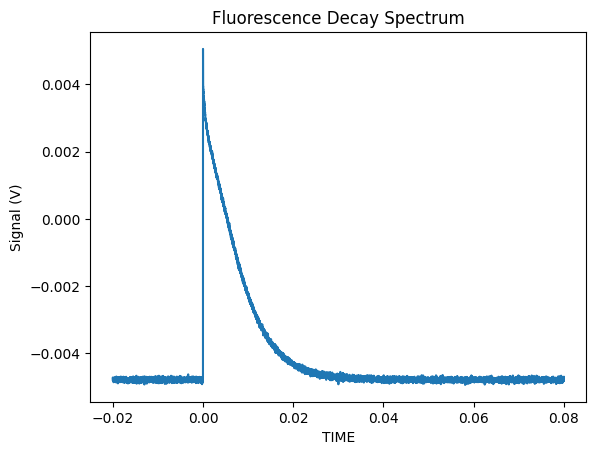

In [34]:
plt.plot(data['TIME'],data['CH1'])
plt.title('Fluorescence Decay Spectrum') #set these appropriately
plt.xlabel('TIME')
plt.ylabel('Signal (V)')
plt.show()

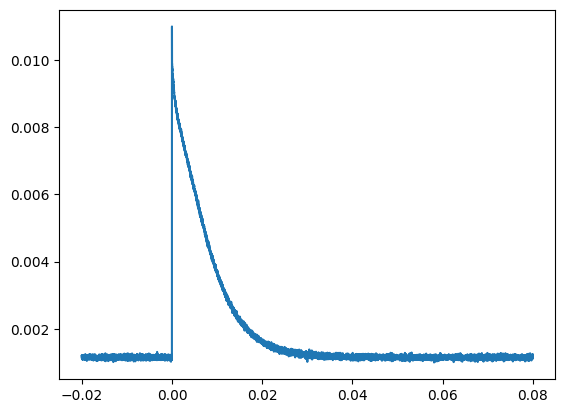

In [35]:
data['normalized ch1'] = data['CH1'] + abs(min(data['CH1'])) + 1e-3
data['ln(CH1+)'] = np.log(data['normalized ch1'])
plt.plot(data['TIME'],data['normalized ch1'])

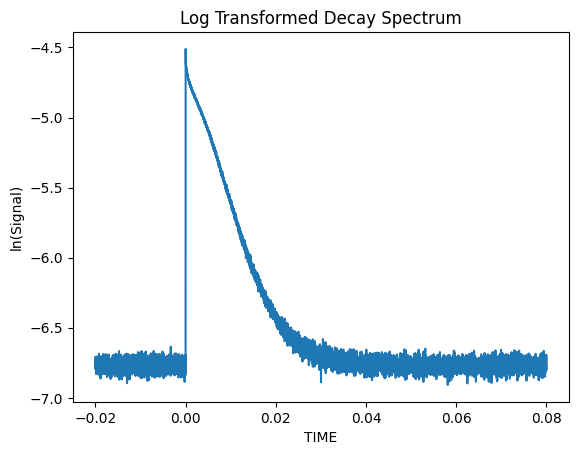

In [36]:
plt.plot(data['TIME'],data['ln(CH1+)'])
plt.title('Log Transformed Decay Spectrum') #set these appropriately
plt.xlabel('TIME')
plt.ylabel('ln(Signal)')
plt.show()

In [37]:
############# performing a linear fit on the valid range

#set time and signal thresholds to filter our data with
time_thresh = 0.0
signal_thresh = 0.01
data = data[data['TIME'] > time_thresh]
data = data[data['normalized ch1'] > signal_thresh]

x = data['TIME']
y = data['ln(CH1+)']

slope, intercept = np.polyfit(x,y,1) # use polyfit
lifetime_tau = -1 / slope
print(f'{lifetime_tau:.6f} s')

TypeError: expected non-empty vector for x

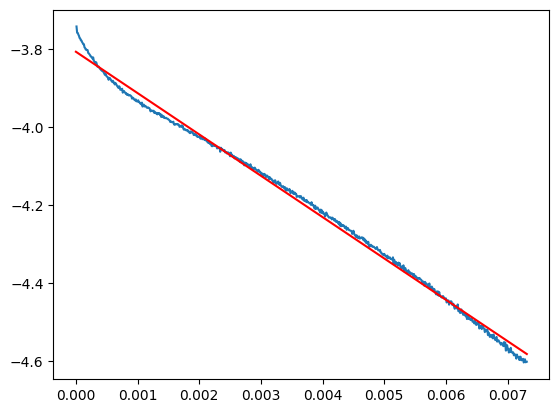

In [ ]:
x_fit = np.linspace(0,x.max(),100)
y_fit = slope * x_fit + intercept
plt.plot(x,y)
plt.plot(x_fit,y_fit,color='red')
plt.show()

### SHORT RESPONSE QUESTIONS
1. Why do we have to add the minimum value of our spectrum to every point before taking the logarithm? Will this offset affect our obtained lifetime values? Why or why not?
2. The fluorescence lifetime (and thus the width of the linear region) will change for each run. How can we ensure that we are only choosing values in the linear region of an arbitrary run if we do not know what time interval it corresponds to?
### ANSWERS

1. We have to add the minimum value of our spectrum to every point so that no values are negative, because the logarithm is not defined for negative values. This offset does affect our obtained lifetime- multiplying by a common factor would not change the slope of our log plot, but addition does. It is therefore important that the baseline is close to zero.
2. Since we cannot base our threshold on a set time region, as this is always changing, a simple solution would be to base our cutoff on the x _and_ y axes instead. We will cut off the region of the signal below where it ceases to be well-behaved.

<br/><br/>

## Automating the Process


Now that we can extract the fluorescence lifetime from each decay curve, we can analyze how this lifetime varies with temperature. But what can we do with this information?

The dependence of lifetime on temperature turns out to contain a surprising amount of information about the competing relaxation pathways of our excited Cr$^{3+}$ ions. Lifetime measurements are kinetic data. In our ruby system, we're considering three energy levels with three relaxation pathways, each with its own rate constant:

- Radiative relaxation from the $^2E$ state (rate constant $A_E$)
- Radiative relaxation from the $^4T_2$ state (rate constant $A_T$)
- Nonradiative (thermal) relaxation from the $^4T_2$ state (rate constant $N(T)$)

The observed fluorescence lifetime $\tau$ is related to the overall relaxation rate by:
$$
A_{overall} = 1/\tau
$$
How will these rate constants combine to give us the overall rate constant?

If all the electrons were in the $^2E$ state:
$$
A_{overall} = A_E
$$
if all the electrons were in the $^4T_2$ state:
$$
A_{overall} = A_T + N(T)
$$
But due to thermal equilibrium, there will be some proportion of electrons in each state, given by the Boltzmann equation:
$$
\frac{n_T}{n_E} = \frac{g_T}{g_E}e^{-(E_T-E_E)/kT} = 8.311e^{-3380/T}
$$
Where $n_T$ and $n_E$ are the populations of each state, $g_T$ and $g_E$ are the degeneracies of each state, $E_T - E_E$ is the energy difference between the two states, $k$ is Boltzmann's constant, and T is temperature.

Therefore, the overall relaxation rate will depend on the proportion of electrons in each state:
$$
1/\tau = A_{overall} = \frac{n_E}{n_E + n_T} \times{}A_E + \frac{n_T}{n_T + n_E}\times{}[A_T + N(T)]
$$
We can simplify this into the following form, which will be most useful for our calculations:
$$
\tau = \frac{1 + \frac{n_T}{n_E}}{A_E + [A_T + N(T)]\frac{n_T}{n_E}}
$$

This is the model we will use to make sense of our lifetime versus temperature data, and it will allow us to determine $A_E$ and $A_T$, along with the activation energy and frequency factor of thermal relaxation.

But first, we must obtain that data. 

### CODE
- Create a function to find lifetime given run number. This function should also accept an argument for whether to plot the data as it processes it (for quality assurance purposes)
- Use this function with plotting enabled for four different trials, including the first and last trial
- Process all of your spectra to get lifetime data for each of them, as an `np.array`
- Create an `np.array` of temperature values corresponding to these lifetimes
- Plot the relationship between lifetime and temperature
- Debug your lifetime function if necessary 

In [38]:
import os
# now we turn it into a function!
def find_lifetime(run_number,plot=False):
    if run_number >= 10:
        filename = f'{data_directory}/tek00{run_number}CH1.csv'
    else:
        filename = f'{data_directory}/tek000{run_number}CH1.csv'
    
    if not os.path.exists(filename):
        print('------------------------')
        print('file does not exist:')
        print(filename)
        print('full path:')
        print(f'directory exists? | {os.path.exists(os.path.dirname(filename))}')
        print(os.path.abspath(filename))
        print('------------------------')
    data = pd.read_csv(filename,skiprows=skip_rows)

    data['CH1+ (V)'] = data['CH1'] + abs(min(data['CH1'])) + 0.001
    data['ln(CH1+)'] = np.log(data['CH1+ (V)'])
    
    time_thresh = 0.0
    signal_min = (data['CH1+ (V)'].max() - data['CH1+ (V)'].min()) * 0.1 + data['CH1+ (V)'].min()  
    signal_max = data['CH1+ (V)'].max() - 0.005
    
    data1 = data[data['TIME'] > time_thresh]
    data1 = data1[data1['CH1+ (V)'] > signal_min]
    # data1 = data1[data1['CH1+ (V)'] < signal_max]
    # data1 = data[data['TIME'] > 0]
    # data2 = data1[data1['ln(CH1+)'] > -4.5]
    
    x = data1['TIME']
    y = data1['ln(CH1+)']
    
    slope, intercept =np.polyfit(x,y,1)
    lifetime_tau = - 1 / slope

    x_fit = np.linspace(0,x.max(),100)
    y_fit = slope * x_fit + intercept
    
    if plot:
        plt.plot(data['TIME'],data['CH1+ (V)'])
        plt.title('Normalized spectrum')
        plt.show()
        plt.plot(data['TIME'],data['ln(CH1+)'])
        plt.title('transformed spectrum')
        plt.show()
        plt.plot(x,y)
        plt.plot(x_fit,y_fit,color='red')
        plt.title('linear fit')
        plt.show()
        
    return lifetime_tau

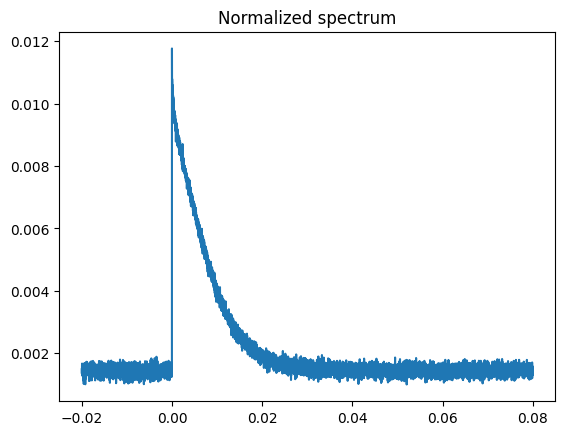

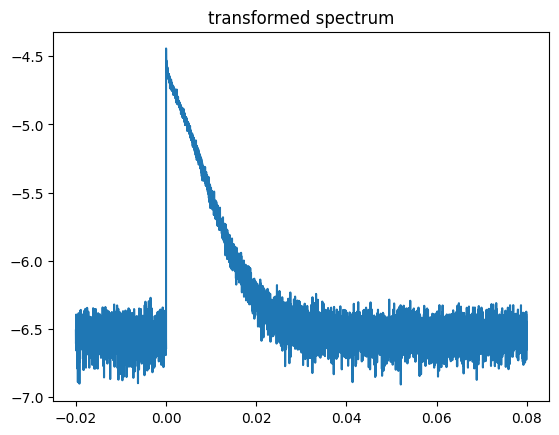

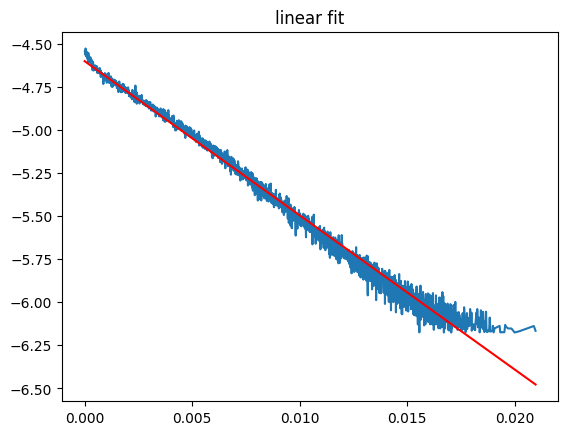

0.01118017429163957

In [39]:
############## call your lifetime function for four different runs
# need to make sure we're choosing the right range for our linear fit
find_lifetime(1,plot=True)

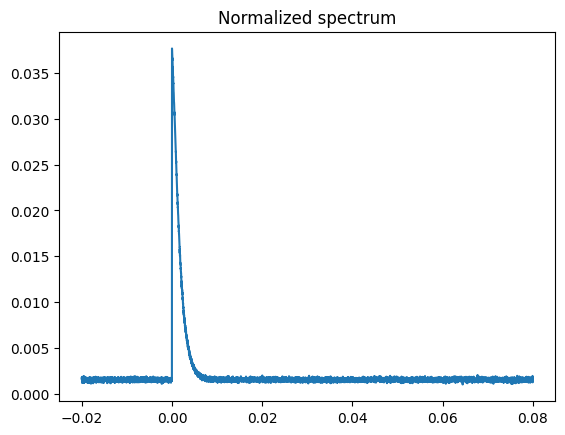

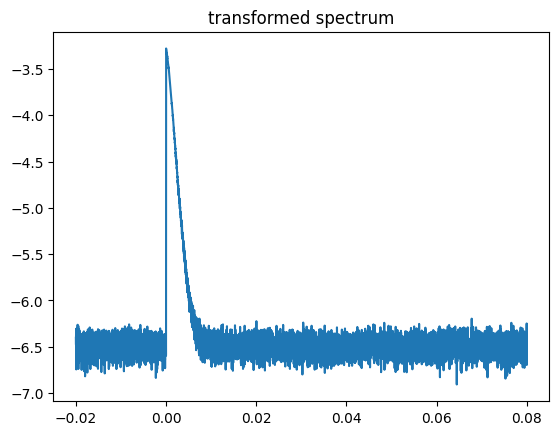

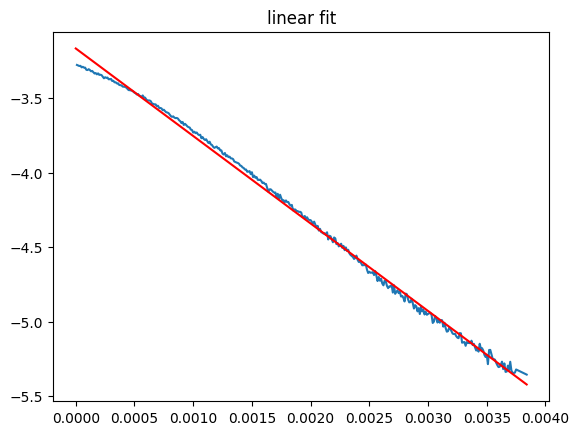

0.0017046319011134244

In [40]:
find_lifetime(43,plot=True)


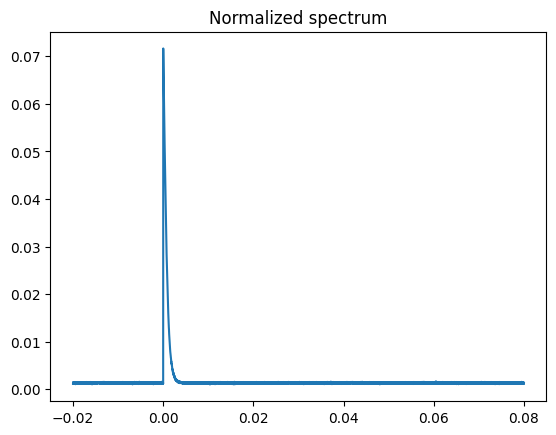

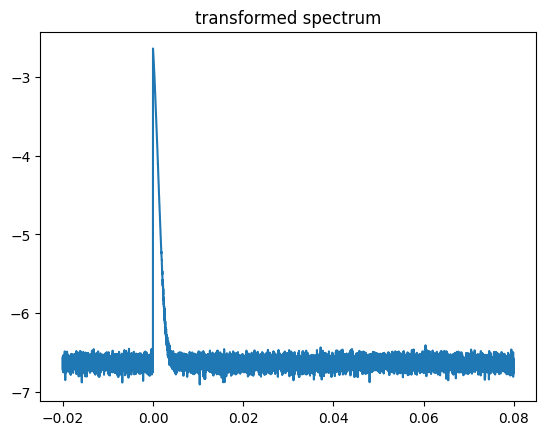

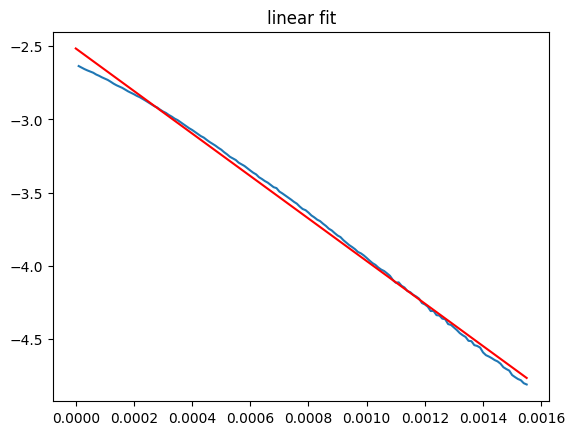

0.0006896209800998142

In [41]:
find_lifetime(60,plot=True)

In [42]:
############ obtaining temperature and lifetime arrays
max_index = 60
run_indices = [i for i in range(max_index+1)] 
temperature_difference = 5
min_temperature = 298
temperatures = np.array([ i* temperature_difference + min_temperature for i in run_indices])
lifetimes = np.array([find_lifetime(i) for i in run_indices])

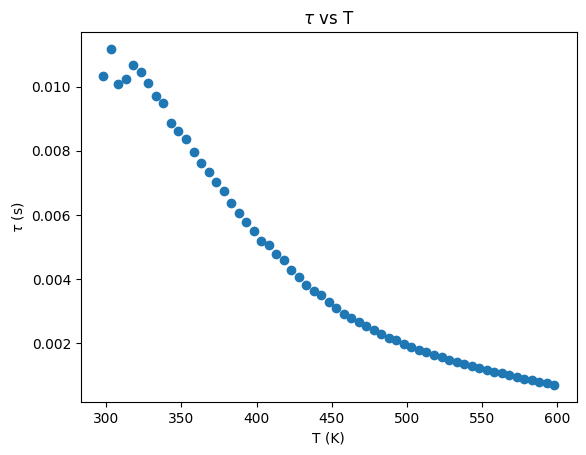

In [43]:
############ plotting

plt.scatter(temperatures,lifetimes)
plt.title('$\\tau$ vs T')
plt.ylabel('$\\tau$ (s)')
plt.xlabel('T (K)')
plt.show()

In [44]:
########## compare to decaying exponential

from scipy.optimize import curve_fit

def decaying_exp(x,A,a,b,c):
    return A * np.exp(-a *( x -b)) +c

In [45]:
guess_params = [0.001,1,400,1] # this is a good first guess, adjust if it doesn't converge
params, cov = curve_fit(decaying_exp,temperatures,lifetimes,guess_params)

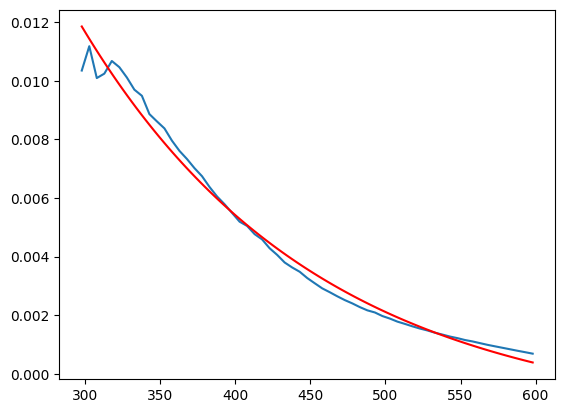

In [46]:
plt.plot(temperatures,lifetimes)
x_fit = np.linspace(temperatures.min(),temperatures.max(),100)
y_fit = decaying_exp(x_fit,*params)
plt.plot(x_fit,y_fit,color='red')
plt.show()

### SHORT RESPONSE QUESTIONS
1. What are the benefits of automatically processing all of our data with a function this way? What are the possible dangers?
2. Did you run into any issues when applying this function to your whole dataset? If so, how did you fix them?
### ANSWERS

1. The benefits of automatically processing our data with a function are that we can perform much, much larger tasks. However, there is a danger of creating a routine which does not work for all of our data and getting erroneous results, or having poor quality data mixed in with our large data set. Quality checking is very important here.
2. Yes, initially I obtained a very jagged and messed up plot of lifetimes versus temperatures. I addressed this by changing the signal cutoff threshold for the linear regression until we got more reasonable results.

<br/><br/>

## Finding A_E and A_T

Alright, now we have our $\tau$ vs $T$ data, and we have an equation to make sense of it:
$$
\tau = \frac{1 + \frac{n_T}{n_E}}{A_E + [A_T + N(T)]\frac{n_T}{n_E}}
$$

But how could we use this to determine any of these parameters, since we don't already know any of them? 

Here is where we run into an important principle in applying mathematical tools to chemistry or physics. __The exact form of this equation gives us less information than an approximation does__.  

If we're willing to cancel out small terms, we will find that $n_T/n_E$ is actually very nearly zero for the first few temperatures in our data set. This simplifies our equation to the much more managable:
$$
A_E = \frac{1}{\tau}
$$
This predicts that lifetime should not depend on temperature; we observe this to be a reasonable approximation for the first few data points, when T is less than 310K.

Once we have calculated $A_E$ in this manner, how can we calculate A_T? We will use the same trick: N(T) depends on a process with a high activation energy, and should thus be very nearly zero for most points on our graph, up to around 600K.

This gives us the following approximation (note: that's "$\frac{n_E}{n_T}$", not "$\frac{n_T}{n_E}$" there):
$$
A_T = \frac{1 + \frac{n_E}{n_T}}{\tau} - \frac{n_E}{n_T}A_E
$$

We will use these formulae to calculate average values of $A_E$ and $A_T$. 

Once this is done, we should also overlay our experimental data with the lifetimes predicted by our simplified model, to ensure that our values are reasonable.

Python makes both of these tasks quite expedient.

### CODE
- Calculate the radiative rate constant A_E using low-temperature data
- Create a model function using only A_E and test its predictions
- Define a function to calculate the Boltzmann population ratio
- Calculate the radiative rate constant A_T using mid-temperature data
- Create an improved model incorporating both A_E and A_T
- Compare your model predictions with experimental data

In [47]:
def calc_AE(tau):
    return 1/tau

In [48]:
# choose a temperature value below which the lifetimes appear flat and linear
mask = temperatures < 320
AE = np.average(calc_AE(lifetimes[mask]))
AE

95.2883121857913

In [49]:
def lifetime_model_AE_only(temperature,AE):
    return 1/AE + temperature * 0

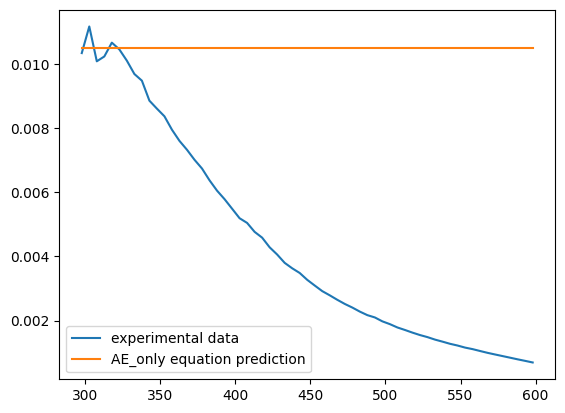

In [50]:
lifetimes_fit = lifetime_model_AE_only(temperatures,AE)
plt.plot(temperatures,lifetimes,label='experimental data')
plt.plot(temperatures,lifetimes_fit,label='AE_only equation prediction')
plt.legend()
plt.show()

In [51]:
def population_ratio(temperature):
    return 8.311*np.exp(-3380/temperature)

In [52]:

def calc_AT(tau,temperature,AE):
    pop_rat = population_ratio(temperature)
    return ((1 + 1/pop_rat ) / ( tau )) - (AE / pop_rat)

In [53]:
# choose reasonable min and max values to find A_T!
# min should be wherever the max was for your A_E calculation
# max should be before N(T) becomes major pathway (around 500K is fine)
at_mask = (temperatures > 310) & (temperatures < 550)
AT = np.average(calc_AT(lifetimes[at_mask],temperatures[at_mask],AE))
AT

42185.89214048543

In [54]:
def lifetime_model_AE_AT(temperature,AE,AT):
    pop_rat = population_ratio(temperature)
    return  (1 + pop_rat) / (AE + AT * pop_rat)

In [55]:
lifetimes_ae_at = lifetime_model_AE_AT(temperatures,AE,AT)
# plot experimental lifetimes and temperatures
# on the same plot as lifetimes predicted with the A_T A_E only model

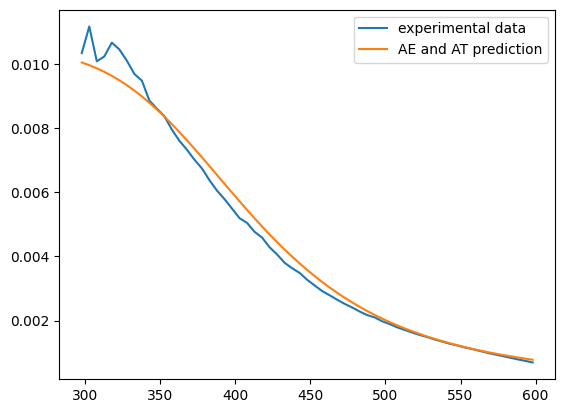

In [56]:
plt.plot(temperatures,lifetimes,label='experimental data')
plt.plot(temperatures,lifetimes_ae_at,label='AE and AT prediction')
plt.legend()
plt.show()

### SHORT RESPONSE QUESTIONS
1. How does the asymptotic behavior of our model incorporating only radiative relaxation compare to the end behavior of the experimental data? What does this tell us about the radiative pathways in our crystal?
### ANSWERS

1. The asymptotic limit of our model seems to overestimate the lifetimes at higher and higher temperatures. This is due to the lack of nonradiative relaxation pathways in our model; incorporating them should predict end behavior more accurately.

<br/><br/>

## Calculating Nonradiative Relaxation Parameters

If we've made it this far, we've calculated $A_E$ and $A_T$, and we're ready to examine the thermal relaxation pathway.
Recall once more the formula 
$$
\tau = \frac{1 + \frac{n_T}{n_E}}{A_E + [A_T + N(T)]\frac{n_T}{n_E}},
$$
Which we are finally able to use in its complete form. We will rearrange to solve for N(T):
$$
N(T) = \frac{1 + \frac{n_E}{n_T}}{\tau} - \frac{n_E}{n_T}A_E - A_T
$$
And we will be able to translate this into a Python function which we can use to calculate N(T) value for each temperature.

Once we have obtained data for $N(T)$ versus $T$, we can expand N(T) into the Arrhenius equation and solve for the frequency factor and activation energy.
$$
N(T) = Ae^{-\frac{E_a}{kT}}
$$
We would like to work with this equation in linear form, as taking a linear regression is a simpler task than fitting it in its current state. Rearranging:
$$
ln(N(T)) = ln(A) + (-\frac{E_a}{k})(\frac{1}{T})
$$
This means we should transform our axes from N(T) to ln(N(T)) and T to 1/T before taking our regression.
The logarithm of the frequency factor will be our intercept, and the negative activation energy divided by Boltzmann's constant will be our slope.

### CODE
- Create a function to calculate nonradiative rate constant N(T)
- Extract N(T) values from high-temperature data
- Plot ln(N(T)) vs. 1/T to determine Arrhenius parameters
- Calculate the activation energy and frequency factor
- Create a complete model that includes all relaxation pathways
- Compare your final model against the experimental data

In [57]:
def calc_NT(tau,temperature):
    pop_rat = population_ratio(temperature)
    return (1 + 1 / pop_rat) / tau - AE / pop_rat - AT

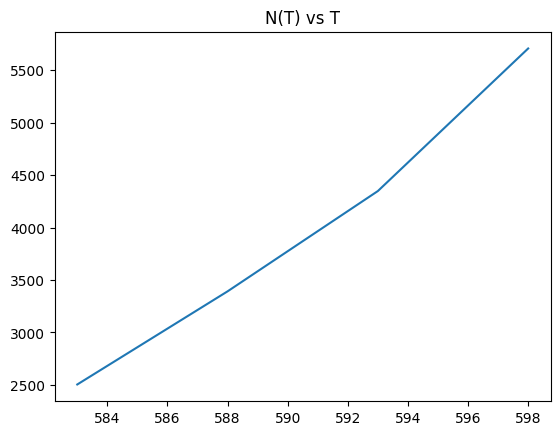

In [58]:
# ~600 is a reasonable value here. as long as all NT values are positive in the plot
nt_mask = temperatures > 580
NT_temperatures = temperatures[nt_mask]

NT_lifetimes = lifetimes[nt_mask]

NT_vals = calc_NT(NT_lifetimes,NT_temperatures)

plt.plot(NT_temperatures,NT_vals)
plt.title('N(T) vs T')
plt.show()

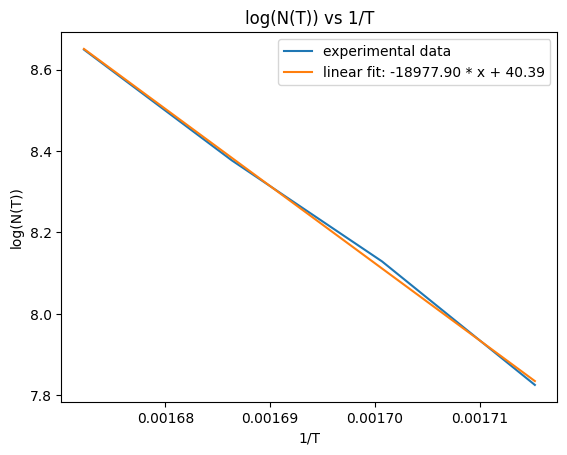

In [59]:
log_NT = np.log(NT_vals)
reciprocal_T = 1/NT_temperatures

slope,intercept= np.polyfit(reciprocal_T,log_NT,1)

x_fit = np.linspace(reciprocal_T.min(),reciprocal_T.max(),100)
y_fit = slope * x_fit + intercept

plt.plot(reciprocal_T,log_NT,label='experimental data')
plt.plot(x_fit,y_fit,label=f'linear fit: {slope:.2f} * x + {intercept:.2f}')
plt.title('log(N(T)) vs 1/T')
plt.xlabel('1/T')
plt.ylabel('log(N(T))')
plt.legend()

plt.show()

In [60]:
# one of these is given by ( - slope ) and one is given by np.exp(intercept). Which is which?
E_trs_over_k = - slope
freqfact = np.exp(intercept)

In [61]:
def NT_model(temperature,E_trs_over_k,freqfact):
    return freqfact * np.exp(- E_trs_over_k/temperature) 

def final_lifetime_model(temperature,AE,AT,E_trs_over_k,freqfact):
    pop_rat = population_ratio(temperature)
    NT = NT_model(temperature,E_trs_over_k,freqfact)
    return (1 + pop_rat) / (AE + pop_rat *(AT + NT ))

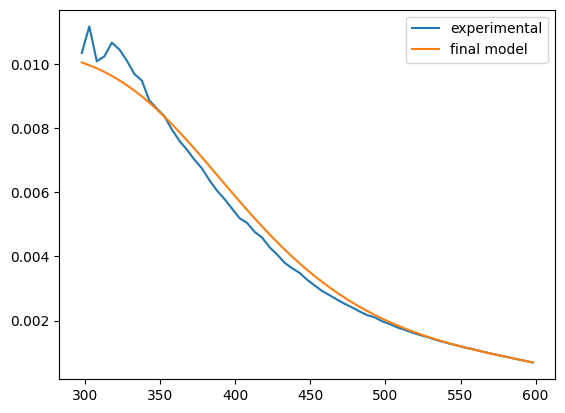

In [62]:
# compare model predictions with experiment.
final_pred_lifetimes = final_lifetime_model(temperatures,AE,AT,E_trs_over_k,freqfact)
plt.plot(temperatures,lifetimes,label='experimental')
plt.plot(temperatures,final_pred_lifetimes,label='final model')
plt.legend()
plt.show()

In [63]:
# calculate activation energy in cm^-1
BOLTZMANN_CONST = 0.695  # cm^-1/K 

E_a = E_trs_over_k * BOLTZMANN_CONST
print(f"Activation energy (cm^-1) : {E_a:.0f}")
print(f"frequency factor: {freqfact:.0f}")

Activation energy (cm^-1) : 13190
frequency factor: 346579195617527680


### SHORT RESPONSE QUESTIONS
1. How does the behavior compare now? What does this say about this version of our model? What might account for any remaining discrepancies?
2. Compare this final model to the initial decaying exponential you fit. What are the advantages of each model? When might you use each?

1. The asymptotic behavior now agrees very closely. This tells us that the missing N(T) term was responsible for the fine-grained disagreement at the end. The discrepancies are likely due to experimental noise (there's a noticeable bump in the lifetimes around 350 to 400) which may skew our fit slightly.
2. This final model predicts the low-temperature and high-temperature limiting behavior more accurately. The exponential model predicts the middle-range data about as well as the final model, however. The explicit model was useful for deriving fine-grained details about the relaxation pathways, but the simple exponential model would be sufficient for predicting the performance of the laser in its normal operating range of temperatures.

<br/><br/>
<br/><br/>

# Reflection

### SHORT RESPONSE QUESTIONS
1. What values were you able to obtain, and what do they physically mean? Is it surprising that so much information is contained in such simple spectra?
2. How did using coarse approximations enable us to gain more information than the full explicit forms of the equations?
3. How did Python make this data processing task possible? Imagine for a moment, trying to do this by hand using Excel. How does the experience compare?
### ANSWER

1. We obtained $A_E$, $A_T$, $\mathcal{A}$, and $E_A$. $A_E$ is the rate of radiative relaxation from the $^2E$ state, which we want for lasing; $A_T$ is the rate of radiative relaxation from the $^4T_2$ state, which is unwanted, and $\mathcal{A}$ and $E_A$ are the Arrhenius parameters for the nonradiative decay pathway. These terms can be used to calculate quantum yield. It is rather interesting that these simple decay spectra can yield so much information about our system, if we know where to look.
2. Using coarse approximations (truncating small terms) allowed us to calculate each of the variables by giving us equations in terms of only 1 unknown. The explicit form had three unknowns and could not have been solved analytically. Approximations were necessary to approach the problem at all!
3. Python massively expedited this process. Processing 80 spectra in this manner using Excel would take hours, at least, and if the task became much larger it would quickly become impossible. However, this took minutes using Python. 